In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
np.random.seed(42)

In [2]:
start = '2010-01-01'
end = '2023-12-31'
stock = 'GOOGL'

data = yf.download(stock, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)

In [ ]:
# Calculate daily returns
data['Return'] = data['Close'].pct_change()

# Calculate rolling volatility (10-day standard deviation)
data['Volatility'] = data['Return'].rolling(10).std()

data['Momentum_5'] = data['Close'] - data['Close'].shift(5)
data['Momentum_10'] = data['Close'] - data['Close'].shift(10)

# RSI (Relative Strength Index)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

# Bollinger Bands
sma_20 = data['Close'].rolling(20).mean()
std_20 = data['Close'].rolling(20).std()
data['Bollinger_Upper'] = sma_20 + (std_20 * 2)
data['Bollinger_Lower'] = sma_20 - (std_20 * 2)
data['Bollinger_Position'] = (data['Close'] - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# Volume-based indicators
data['Price_Change'] = data['Close'].pct_change()
data['MA_20'] = data['Close'].rolling(20).mean()
data['MA_50'] = data['Close'].rolling(50).mean()

data.dropna(inplace=True)


In [ ]:
# Volatility-adjusted multi-day trend labeling
horizon = 3
vol_threshold_multiplier = 0.8


def classify_trend_with_dynamic_threshold(fwd_return, dyn_threshold):
    if fwd_return > dyn_threshold:
        return 2  # UP
    if fwd_return < -dyn_threshold:
        return 0  # DOWN
    return 1      # STABLE


data['Forward_Return'] = data['Close'].shift(-horizon) / data['Close'] - 1.0
data['Dynamic_Threshold'] = vol_threshold_multiplier * data['Volatility'] * np.sqrt(horizon)

data['Trend'] = data.apply(
    lambda row: classify_trend_with_dynamic_threshold(row['Forward_Return'], row['Dynamic_Threshold']),
    axis=1,
)

data = data.dropna(subset=['Forward_Return', 'Dynamic_Threshold', 'Trend']).copy()
data['Trend'] = data['Trend'].astype('int32')


In [ ]:
data[['Return', 'Forward_Return', 'Dynamic_Threshold', 'Trend']].head(10)


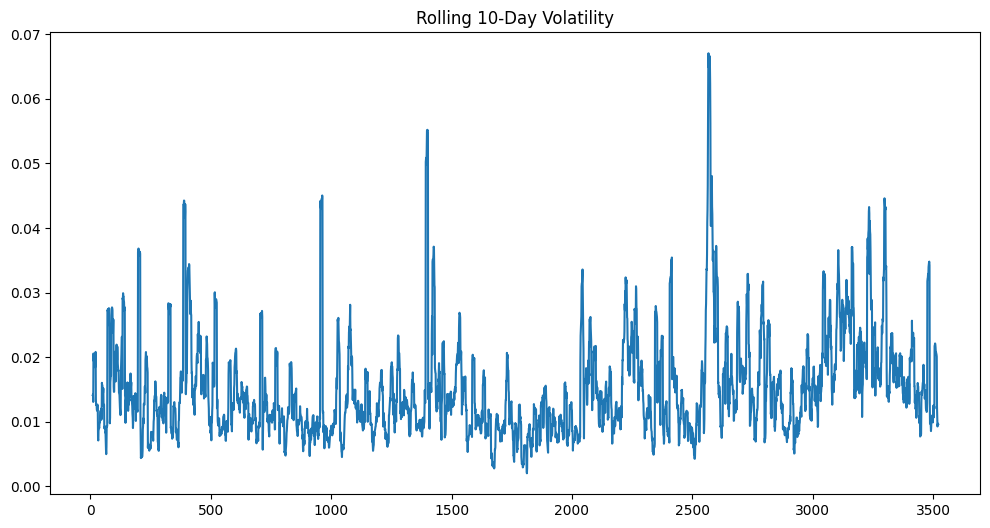

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Volatility'])
plt.title("Rolling 10-Day Volatility")
plt.show()

In [8]:
ma_100_days = data.Close.rolling(100).mean()

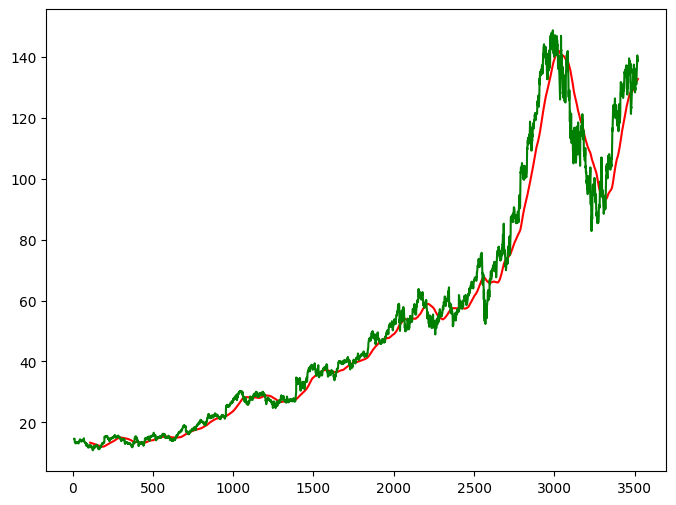

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [10]:
ma_200_days = data.Close.rolling(200).mean()

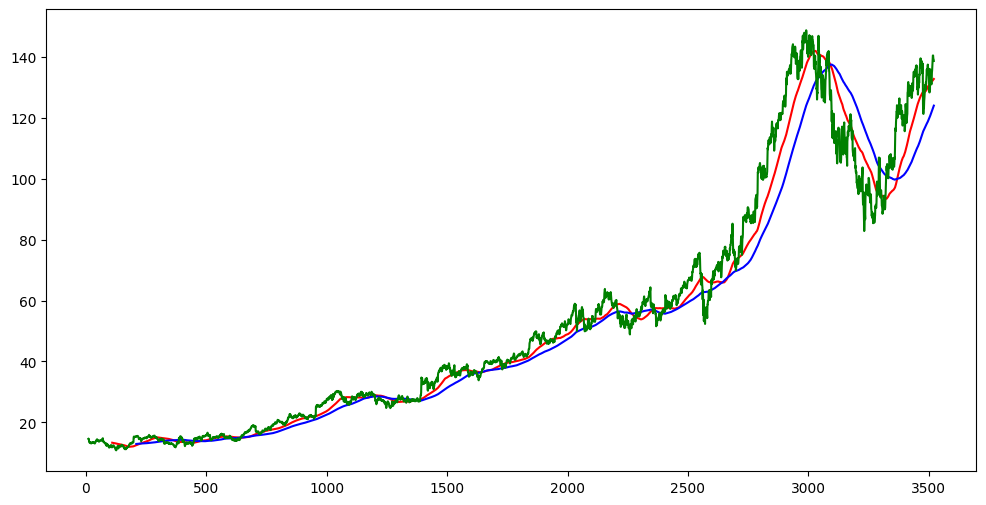

In [11]:
plt.figure(figsize=(12,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [12]:
split_index = int(len(data)*0.80)

data_train = data[:split_index]
data_test = data[split_index:]

In [13]:
data_train.shape[0], data_test.shape[0] 

(2809, 703)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature set for sequence modeling
features = [
    'Close', 'Return', 'Volatility', 'Momentum_5', 'Momentum_10',
    'RSI', 'MACD', 'MACD_Histogram', 'Bollinger_Position',
    'Price_Change', 'MA_20', 'MA_50'
]

label_col = 'Trend'
seq_len = 100


In [ ]:
def make_sequences(feature_array, label_array, seq_len):
    x, y = [], []
    for i in range(seq_len, len(feature_array)):
        x.append(feature_array[i - seq_len:i])
        y.append(label_array[i])

    if len(x) == 0:
        return np.empty((0, seq_len, feature_array.shape[1]), dtype='float32'), np.empty((0,), dtype='int32')

    return np.array(x, dtype='float32'), np.array(y, dtype='int32')


def prepare_train_test_sequences(train_df, test_df, features, label_col, seq_len):
    scaler = MinMaxScaler()

    train_features = train_df[features].values
    test_features = test_df[features].values

    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    y_train_raw = train_df[label_col].values.astype('int32')
    y_test_raw = test_df[label_col].values.astype('int32')

    x_train, y_train = make_sequences(train_scaled, y_train_raw, seq_len)

    # Build test windows with train tail context, still leakage-safe because scaler is fit on train only.
    combined_scaled = np.vstack([train_scaled[-seq_len:], test_scaled])
    combined_labels = np.concatenate([y_train_raw[-seq_len:], y_test_raw])
    x_test, y_test = make_sequences(combined_scaled, combined_labels, seq_len)

    test_dates = test_df['Date'].values[:len(y_test)]

    return x_train, y_train, x_test, y_test, test_dates


def build_class_weight_dict(y):
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return dict(zip(classes, weights))


In [ ]:
x_train_all, y_train_all, x_test, y_test, test_dates = prepare_train_test_sequences(
    data_train,
    data_test,
    features,
    label_col,
    seq_len,
)

print('x_train_all shape:', x_train_all.shape)
print('y_train_all shape:', y_train_all.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


In [ ]:
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


def build_model(input_shape):
    model = Sequential()

    model.add(Bidirectional(LSTM(
        100,
        return_sequences=True,
        input_shape=input_shape,
        kernel_regularizer=l2(0.001),
    )))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model


In [ ]:
# Walk-forward validation for realistic time-series evaluation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score

wf_metrics = []
ts_cv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(ts_cv.split(data), start=1):
    fold_train = data.iloc[train_idx].copy()
    fold_val = data.iloc[val_idx].copy()

    x_tr, y_tr, x_val, y_val, _ = prepare_train_test_sequences(
        fold_train,
        fold_val,
        features,
        label_col,
        seq_len,
    )

    if len(x_tr) == 0 or len(x_val) == 0:
        print(f'Fold {fold}: skipped (insufficient sequence length).')
        continue

    fold_model = build_model((x_tr.shape[1], x_tr.shape[2]))
    fold_class_weights = build_class_weight_dict(y_tr)
    fold_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    fold_model.fit(
        x_tr,
        y_tr,
        epochs=35,
        batch_size=32,
        validation_split=0.1,
        class_weight=fold_class_weights,
        callbacks=[fold_stop],
        verbose=0,
    )

    fold_probs = fold_model.predict(x_val, verbose=0)
    fold_pred = np.argmax(fold_probs, axis=1)

    fold_acc = accuracy_score(y_val, fold_pred)
    fold_f1 = f1_score(y_val, fold_pred, average='macro')

    wf_metrics.append({'Fold': fold, 'Accuracy': fold_acc, 'Macro_F1': fold_f1})
    print(f"Fold {fold} -> Accuracy: {fold_acc:.4f}, Macro-F1: {fold_f1:.4f}")

wf_df = pd.DataFrame(wf_metrics)

print('')
if len(wf_df) > 0:
    print('Walk-forward summary:')
    print(wf_df)
    print('')
    print(f"Mean Accuracy: {wf_df['Accuracy'].mean():.4f}")
    print(f"Mean Macro-F1: {wf_df['Macro_F1'].mean():.4f}")
else:
    print('No valid walk-forward folds produced metrics.')


In [ ]:
# Train final model on train split and keep a calibration subset
from sklearn.linear_model import LogisticRegression


def apply_probability_calibration(raw_probs, calibrator, n_classes=3):
    if calibrator is None:
        return raw_probs

    calibrated_partial = calibrator.predict_proba(raw_probs)
    calibrated_full = np.zeros((len(raw_probs), n_classes), dtype='float64')
    calibrated_full[:, calibrator.classes_.astype(int)] = calibrated_partial

    row_sum = calibrated_full.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0.0] = 1.0
    return calibrated_full / row_sum


base_model = build_model((x_train_all.shape[1], x_train_all.shape[2]))

# Use the most recent part of the train set as calibration data.
calibrator = None
if len(x_train_all) >= 300:
    calib_size = max(60, int(0.2 * len(x_train_all)))
    x_fit = x_train_all[:-calib_size]
    y_fit = y_train_all[:-calib_size]
    x_cal = x_train_all[-calib_size:]
    y_cal = y_train_all[-calib_size:]
else:
    x_fit = x_train_all
    y_fit = y_train_all
    x_cal = np.empty((0, x_train_all.shape[1], x_train_all.shape[2]), dtype='float32')
    y_cal = np.empty((0,), dtype='int32')

final_class_weights = build_class_weight_dict(y_fit)
final_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = base_model.fit(
    x_fit,
    y_fit,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=final_class_weights,
    callbacks=[final_stop],
    verbose=1,
)

if len(x_cal) > 0 and len(np.unique(y_cal)) >= 2:
    cal_raw_probs = base_model.predict(x_cal, verbose=0)
    calibrator = LogisticRegression(max_iter=2000, multi_class='multinomial')
    calibrator.fit(cal_raw_probs, y_cal)
    print(f'Calibration model trained on {len(x_cal)} recent training samples.')
else:
    print('Calibration skipped due to insufficient calibration split.')


In [ ]:
print('Final training set size:', len(x_fit))
print('Calibration set size:', len(x_cal))
print('Test sequence size:', len(x_test))


In [ ]:
from sklearn.metrics import accuracy_score

# Raw probabilities from neural model
y_pred_probs_raw = base_model.predict(x_test, verbose=0)
y_pred_raw = np.argmax(y_pred_probs_raw, axis=1)

# Calibrated probabilities
y_pred_probs = apply_probability_calibration(y_pred_probs_raw, calibrator, n_classes=3)
y_pred = np.argmax(y_pred_probs, axis=1)

raw_acc = accuracy_score(y_test, y_pred_raw)
cal_acc = accuracy_score(y_test, y_pred)

print(f'Test Accuracy (raw): {raw_acc:.4f}')
print(f'Test Accuracy (calibrated): {cal_acc:.4f}')


In [ ]:
def expected_calibration_error(y_true, probs, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    correctness = (predictions == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for b in range(n_bins):
        lo, hi = bins[b], bins[b + 1]
        if b == n_bins - 1:
            in_bin = (confidences >= lo) & (confidences <= hi)
        else:
            in_bin = (confidences >= lo) & (confidences < hi)

        if np.any(in_bin):
            bin_acc = np.mean(correctness[in_bin])
            bin_conf = np.mean(confidences[in_bin])
            ece += np.mean(in_bin) * abs(bin_acc - bin_conf)

    return float(ece)


raw_ece = expected_calibration_error(y_test, y_pred_probs_raw)
cal_ece = expected_calibration_error(y_test, y_pred_probs)

print(f'ECE (raw): {raw_ece:.4f}')
print(f'ECE (calibrated): {cal_ece:.4f}')

confidence = np.max(y_pred_probs, axis=1)
print('First 10 calibrated confidence values:')
print(confidence[:10])


In [ ]:
# Enhanced confidence bands + Monte Carlo uncertainty + risk scoring
confidence_scores = np.max(y_pred_probs, axis=1)

# Align price/volatility with prediction rows
test_aligned = data_test.iloc[:len(y_test)].reset_index(drop=True)
volatility_test = test_aligned['Volatility'].values
close_test = test_aligned['Close'].values

# Risk score from current market uncertainty (0-100)
vol_q33 = np.quantile(volatility_test, 0.33)
vol_q67 = np.quantile(volatility_test, 0.67)
vol_min = np.min(volatility_test)
vol_max = np.max(volatility_test)


def volatility_to_risk_score(v):
    if vol_max == vol_min:
        return 50.0
    score = 100.0 * (v - vol_min) / (vol_max - vol_min)
    return float(np.clip(score, 0, 100))


def categorize_risk(v):
    if v < vol_q33:
        return 'Stable'
    if v < vol_q67:
        return 'Risky'
    return 'Highly Volatile'


risk_scores = np.array([volatility_to_risk_score(v) for v in volatility_test])
risk_categories = [categorize_risk(v) for v in volatility_test]

# Monte Carlo confidence band for horizon return uncertainty
n_sims = 1000
expected_return = (y_pred_probs[:, 2] - y_pred_probs[:, 0]) * np.mean(test_aligned['Dynamic_Threshold'].values)

mc_lower = []
mc_upper = []
mc_mean = []

for i in range(len(test_aligned)):
    current_price = close_test[i]
    sigma = max(volatility_test[i], 1e-6) * np.sqrt(horizon)
    conf_scale = 1.5 - confidence_scores[i]  # lower confidence => wider uncertainty

    sim_returns = np.random.normal(
        loc=expected_return[i],
        scale=sigma * conf_scale,
        size=n_sims,
    )
    sim_prices = current_price * (1.0 + sim_returns)

    mc_mean.append(float(np.mean(sim_prices)))
    mc_lower.append(float(np.percentile(sim_prices, 2.5)))
    mc_upper.append(float(np.percentile(sim_prices, 97.5)))

results_df = pd.DataFrame({
    'Date': test_aligned['Date'].values,
    'Close': close_test,
    'Actual_Trend': y_test,
    'Predicted_Trend': y_pred,
    'Confidence': confidence_scores,
    'Volatility': volatility_test,
    'Risk_Score': risk_scores,
    'Risk_Category': risk_categories,
    'Expected_Return': expected_return,
    'MC_Mean_Price': mc_mean,
    'MC_Lower_95': mc_lower,
    'MC_Upper_95': mc_upper,
})

trend_labels = {0: 'DOWN', 1: 'STABLE', 2: 'UP'}
results_df['Actual_Label'] = results_df['Actual_Trend'].map(trend_labels)
results_df['Predicted_Label'] = results_df['Predicted_Trend'].map(trend_labels)

print('')
print('First 10 predictions with confidence, risk score, and Monte Carlo band:')
print(results_df[['Date', 'Actual_Label', 'Predicted_Label', 'Confidence', 'Risk_Score', 'Risk_Category', 'MC_Lower_95', 'MC_Upper_95']].head(10))


In [ ]:
# Prediction Failure Analyzer
results_df['Correct'] = results_df['Actual_Trend'] == results_df['Predicted_Trend']
failures = results_df[~results_df['Correct']].copy()

print('')
print(f"Total Predictions: {len(results_df)}")
print(f"Correct Predictions: {results_df['Correct'].sum()}")
print(f"Failed Predictions: {len(failures)}")
print(f"Overall Accuracy: {(results_df['Correct'].sum() / len(results_df)) * 100:.2f}%")

print('')
print("=== PREDICTION FAILURE ANALYZER ===")

# Failure rate by market state
for category in ['Stable', 'Risky', 'Highly Volatile']:
    bucket = results_df[results_df['Risk_Category'] == category]
    if len(bucket) == 0:
        continue
    failure_count = (~bucket['Correct']).sum()
    failure_rate = 100.0 * failure_count / len(bucket)
    print(f"{category}: {failure_rate:.2f}% failures ({failure_count}/{len(bucket)})")

correct_conf = results_df.loc[results_df['Correct'], 'Confidence'].mean()
failed_conf = results_df.loc[~results_df['Correct'], 'Confidence'].mean()
print('')
print(f"Average Confidence - Correct: {correct_conf:.4f}")
print(f"Average Confidence - Failed: {failed_conf:.4f}")

# Root-cause heuristic labeling for each failed prediction
vol_spike_cutoff = results_df['Volatility'].quantile(0.90)
low_conf_cutoff = results_df['Confidence'].quantile(0.25)

cause_labels = []
for _, row in failures.iterrows():
    causes = []
    if row['Volatility'] >= vol_spike_cutoff:
        causes.append('Volatility Spike')
    if row['Risk_Category'] == 'Highly Volatile':
        causes.append('Abnormal Market Regime')
    if row['Confidence'] <= low_conf_cutoff:
        causes.append('Low Model Confidence')
    if not causes:
        causes.append('Ambiguous Trend Transition')
    cause_labels.append(' | '.join(causes))

if len(failures) > 0:
    failures = failures.assign(Failure_Cause=cause_labels)
    print('')
    print("Top inferred failure causes:")
    print(failures['Failure_Cause'].value_counts().head(10))
    print('')
    print("Failure samples:")
    print(failures[['Date', 'Actual_Label', 'Predicted_Label', 'Confidence', 'Volatility', 'Risk_Category', 'Failure_Cause']].head(10))
else:
    print("No failures found on test set.")


In [ ]:
# Detailed Accuracy Metrics by Trend Class
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print('')
print('=== DETAILED CLASSIFICATION METRICS ===')
print('')
print(classification_report(y_test, y_pred, target_names=['DOWN', 'STABLE', 'UP']))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues', aspect='auto')

ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(['DOWN', 'STABLE', 'UP'])
ax.set_yticklabels(['DOWN', 'STABLE', 'UP'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=13)

ax.set_title('Confusion Matrix - Calibrated Trend Predictions')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print('')
print('=== CONFIDENCE ANALYSIS (CALIBRATED) ===')
print(f"Mean Confidence: {confidence_scores.mean():.4f}")
print(f"Median Confidence: {np.median(confidence_scores):.4f}")
print(f"Min Confidence: {confidence_scores.min():.4f}")
print(f"Max Confidence: {confidence_scores.max():.4f}")
print(f"Std Dev Confidence: {confidence_scores.std():.4f}")


In [ ]:
# Training History Visualization (if history exists)
if 'history' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Training completed in {len(history.history['loss'])} epochs")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
else:
    print("Training history not available - model was trained successfully")
    print(f"Test Accuracy: {(results_df['Correct'].sum() / len(results_df)) * 100:.2f}%")


Training history not available - model was trained successfully
Test Accuracy: 29.68%


In [ ]:
# Prediction confidence + Monte Carlo confidence band visualization
fig, ax1 = plt.subplots(figsize=(14, 6))

x_axis = np.arange(len(results_df))

# Confidence line
ax1.plot(x_axis, results_df['Confidence'], color='tab:blue', alpha=0.8, label='Prediction Confidence')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.6, label='50% Confidence')
ax1.set_ylabel('Model Confidence', color='tab:blue')
ax1.set_xlabel('Predictions (Chronological Order)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1.05)

# Monte Carlo band on secondary axis (price scale)
ax2 = ax1.twinx()
ax2.plot(x_axis, results_df['Close'], color='black', alpha=0.5, label='Observed Close')
ax2.plot(x_axis, results_df['MC_Mean_Price'], color='tab:green', alpha=0.9, label='MC Mean Next Price')
ax2.fill_between(
    x_axis,
    results_df['MC_Lower_95'],
    results_df['MC_Upper_95'],
    color='tab:red',
    alpha=0.18,
    label='Monte Carlo 95% Band'
)
ax2.set_ylabel('Price / Band')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Trend Prediction Confidence with Monte Carlo Uncertainty Band')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Monte Carlo 95% band visualizes uncertainty-aware prediction intervals.")


## Model Improvements Summary

### 1. Volatility-Adjusted Multi-Day Labels
- Trend labels use **forward return over multiple days** (`horizon=3`) instead of noisy next-day movement.
- Decision boundary is dynamic: `threshold = k * rolling_volatility * sqrt(horizon)`.
- This makes `STABLE` adaptive to market regime instead of fixed-percentage heuristics.

### 2. Walk-Forward Validation
- Added **TimeSeriesSplit** walk-forward evaluation (5 folds).
- Each fold fits scaler on train only and evaluates on future slice.
- Reports fold-wise and mean Accuracy / Macro-F1 for realistic temporal generalization.

### 3. Confidence Calibration
- Final model is trained on train split, with recent train tail reserved as calibration set.
- A multinomial logistic calibrator maps raw softmax outputs to calibrated probabilities.
- Reports ECE before and after calibration to verify confidence quality.

### 4. Uncertainty + Risk Layer
- Monte Carlo confidence bands remain in place with volatility-conditioned simulation.
- Risk scoring and regime labels (`Stable`, `Risky`, `Highly Volatile`) are retained.
- Prediction failure analyzer is kept to explain likely failure causes.

These updates improve reliability and interpretability, aligning the notebook more closely with uncertainty-aware trend decision support.


In [ ]:
# Save model + optional probability calibrator
import joblib

model = base_model
save_model_path = r'C:/Users/Anvika/GitHub/Rtrp/Stock Predictions Model.keras'
model.save(save_model_path)
print(f'Model saved successfully to: {save_model_path}')

if calibrator is not None:
    save_cal_path = r'C:/Users/Anvika/GitHub/Rtrp/probability_calibrator.pkl'
    joblib.dump(calibrator, save_cal_path)
    print(f'Calibrator saved successfully to: {save_cal_path}')
else:
    print('Calibrator not saved (not trained).')

print('')
print('Model Summary:')
print(f"- Total Parameters: {model.count_params():,}")
print('- Objective: 3-class trend prediction (DOWN/STABLE/UP)')
print('- Labels: volatility-adjusted multi-day trend')
print('- Evaluation: walk-forward + holdout')
print('- Uncertainty: calibrated confidence + Monte Carlo band + risk score')

if 'results_df' in dir():
    test_accuracy = float(results_df['Correct'].mean())
    print(f"- Test Accuracy (calibrated): {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

if 'wf_df' in dir() and len(wf_df) > 0:
    print(f"- Walk-forward Mean Accuracy: {wf_df['Accuracy'].mean():.4f}")
    print(f"- Walk-forward Mean Macro-F1: {wf_df['Macro_F1'].mean():.4f}")

if 'history' in dir():
    print(f"- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
